# M8/M5 - DIN Analyisis

Physical Parameters to see if shelf water is being advected to M8

**M5:** 59 54.91 N; 171 42.070 W   
**M8:** 62 12.00 N; 174 40.770 W

__Authors:__ Shaun Bell, Cal Mordy

35hr filtered - daily averaged:   
- bottom temperature (50m)
- 10m and 50m currents
- Salinity 50m (if using erddap hosted data, watch out for deployments with all empty fields)
- collocated RCMs

Daily Data
- NARR winds (from ESRL/PSD)


In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter

import cmocean

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

In [2]:
e = ERDDAP(server=server_url)
df = pd.read_csv(e.get_search_url(response='csv', search_for='bs8'))

print(df['Dataset ID'].values)

['1hr_gridded_datasets_Mooring_05bs8a_final'
 '1hr_gridded_datasets_Mooring_05bs8b_final'
 '1hr_gridded_datasets_Mooring_06bs8a_final'
 '1hr_gridded_datasets_Mooring_07bs8a_final'
 '1hr_gridded_datasets_Mooring_08bs8a_final'
 '1hr_gridded_datasets_Mooring_09bs8a_final'
 '1hr_gridded_datasets_Mooring_10bs8a_final'
 '1hr_gridded_datasets_Mooring_11bs8a_final'
 '1hr_gridded_datasets_Mooring_12bs8a_final'
 '1hr_gridded_datasets_Mooring_13bs8a_final'
 '1hr_gridded_datasets_Mooring_14bs8a_final'
 '1hr_gridded_datasets_Mooring_15bs8a_final'
 '1hr_gridded_datasets_Mooring_16bs8a_final'
 '1hr_gridded_datasets_Mooring_17bs8a_final'
 '1hr_gridded_datasets_Mooring_18bs8a_final'
 'datasets_Mooring_05bs8a_final' 'datasets_Mooring_05bs8b_final'
 'datasets_Mooring_06bs8a_final' 'datasets_Mooring_07bs8a_final'
 'datasets_Mooring_08bs8a_final' 'datasets_Mooring_09bs8a_final'
 'datasets_Mooring_10bs8a_final' 'datasets_Mooring_11bs8a_final'
 'datasets_Mooring_12bs8a_final' 'datasets_Mooring_13bs8a_final'


Get **Salinity and Temperature** only (and depth/time)

In [3]:
from requests.exceptions import HTTPError

dfs = {}
for dataset_id in df['Dataset ID'].values:
    if '1hr_gridded' in dataset_id:
        continue
    print(dataset_id)
    try:
        d = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        d.dataset_id=dataset_id
        d.variables = ['time','depth','salinity','temperature']
        d.constraints
    except HTTPError:
        print('Failed to generate url {}'.format(dataset_id))

    try:
        df_m = d.to_pandas(
                    index_col='time (UTC)',
                    parse_dates=True,
                    skiprows=(1,)  # units information can be dropped.
                    )
        df_m.sort_index(inplace=True)
        df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]
        
        #-9999 and 1e35 are missing values... but erddap doesn't catch the -9999 yet 
        #and some 1e35 are off a bit
        df_m['depth'][(df_m.depth == -9999)] = np.nan # only in pressure field
        dfs.update({dataset_id:df_m})
    except:
        pass


datasets_Mooring_05bs8a_final
datasets_Mooring_05bs8b_final
datasets_Mooring_06bs8a_final
datasets_Mooring_07bs8a_final
datasets_Mooring_08bs8a_final
datasets_Mooring_09bs8a_final
datasets_Mooring_10bs8a_final
datasets_Mooring_11bs8a_final
datasets_Mooring_12bs8a_final
datasets_Mooring_13bs8a_final
datasets_Mooring_14bs8a_final
datasets_Mooring_15bs8a_final
datasets_Mooring_16bs8a_final
datasets_Mooring_17bs8a_final
datasets_Mooring_18bs8a_final
datasets_Mooring_13bs8a_preliminary
datasets_Mooring_14bs8a_preliminary
datasets_Mooring_15bs8a_preliminary
datasets_Mooring_16bs8a_preliminary
datasets_Mooring_17bs8a_preliminary
datasets_Mooring_18bs8a_preliminary


In [39]:
### final only with filtered data
import sys
try:
    # The insertion index should be 1 because index 0 is this file
    sys.path.insert(1, '/Users/bell/Programs/Python/EcoFOCI_Jupyter_Notebooks/filters')  # the type of path is string
    # because the system path already have the absolute path to folder a
    # so it can recognize file_a.py while searching 
    import lanzcos
except (ModuleNotFoundError, ImportError) as e:
    print("{} fileure".format(type(e)))
else:
    print("Import succeeded")



Import succeeded


In [ ]:
#group by depth
parameter='salinity'
parameter_drop=['temperature']

fig, (ax1) = plt.subplots(1,1,sharex='col',figsize=(12,3))
for dfn, df in dfs.items():
    df[df >1e34] = np.nan #replace missing with nan's
    dfg = df.groupby('depth')
    
    for ds in dfg.groups:
        if (ds > 50) and (ds < 61):
            print(f"{dfn}: {ds}")
            
            try:
                dft = dfg.get_group(ds).drop(parameter_drop,axis=1).dropna()

                if (not np.isnan(dft[parameter]).all()):

                    #
                    ## missing data fill limited by number of hours to linearly interpolate
                    temp = dft[parameter].interpolate(method='time',limit=6)

                    # get index of missing data that wasn't filled
                    # the remaining missing data will continue to be missing after analysis
                    # this data and the edges of the timeseries need to have the effects of the filter window accounted for

                    missing_index = np.isnan(temp)
                    temp = dft[parameter].interpolate(method='time')

                    #address gaps at beginning and end... back fill... and forward fill at end... 
                    # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
                    temp.bfill(inplace=True)
                    temp.ffill(inplace=True)

                    #filter data with lanzcos filter
                    dft[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + dft[parameter].mean()
                    
                    #plot
                    ax1.plot(dft.index.values, dft[parameter],'r',linewidth=.5, label=dfn)
                    ax1.plot(dft.index.values, dft[parameter+'_f35'],'k',linewidth=1.5, label=dfn)
                    dft.to_csv(dfn+'_'+parameter+'.csv')
                else:
                    continue
            except:
                continue
        elif (ds > 48) and (ds < 62):
            #print(f"{dfn}: {ds}")
            pass

#ax1.legend()
ax1.set_ylim([30, 33])

In [5]:
import xarray as xa

In [67]:
e = ERDDAP(server=server_url)
# searchterm mooring... subset this later
df = pd.read_csv(e.get_search_url(response='csv', search_for='ADCP'))

In [68]:
print(df['Dataset ID'].values)

['ADCP_Mooring_05bsp5a_final' 'ADCP_Mooring_05bsp8a_final'
 'ADCP_Mooring_05bsp8b_final' 'ADCP_Mooring_06bsp5b_final'
 'ADCP_Mooring_06bsp8a_final' 'ADCP_Mooring_07bsp5a_final'
 'ADCP_Mooring_07bsp8a_final' 'ADCP_Mooring_08bsp5b_final'
 'ADCP_Mooring_08bsp8a_final' 'ADCP_Mooring_09bsp5a_final'
 'ADCP_Mooring_10bsp8a_final' 'ADCP_Mooring_10ckp1a_final'
 'ADCP_Mooring_10ckp2a_final' 'ADCP_Mooring_10ckp3a_final'
 'ADCP_Mooring_11bsp5a_final' 'ADCP_Mooring_11bsp5b_final'
 'ADCP_Mooring_11bsp8a_final' 'ADCP_Mooring_11ckp2a_final'
 'ADCP_Mooring_11ckp3a_final' 'ADCP_Mooring_12bsp2a_final'
 'ADCP_Mooring_12bsp2b_final' 'ADCP_Mooring_12bsp5a_final'
 'ADCP_Mooring_13bsp2a_final' 'ADCP_Mooring_13bsp2b_final'
 'ADCP_Mooring_13bsp8a_final' 'ADCP_Mooring_13ckp1a_final'
 'ADCP_Mooring_13ckp2a_final' 'ADCP_Mooring_13ckp5a_final'
 'ADCP_Mooring_14bsp2a_final' 'ADCP_Mooring_14bsp5a_final'
 'ADCP_Mooring_14bsp8a_final' 'ADCP_Mooring_14ckp1a_final'
 'ADCP_Mooring_14ckp4a_final' 'ADCP_Mooring_14ckp5a_fina

In [75]:
from requests.exceptions import HTTPError

dfg = {}
for dataset_id in df['Dataset ID']:
    if ('bsp5' in dataset_id):
        try:
            print(dataset_id)
            e.constraints = None
            e.protocol = 'griddap'

            e.dataset_id=dataset_id
            e.response = 'nc'
            ds = e.to_xarray(decode_times=True)
            dfg.update({dataset_id:ds})
        except:
            pass

ADCP_Mooring_05bsp5a_final
ADCP_Mooring_06bsp5b_final
ADCP_Mooring_07bsp5a_final
ADCP_Mooring_08bsp5b_final
ADCP_Mooring_09bsp5a_final
ADCP_Mooring_11bsp5a_final
ADCP_Mooring_11bsp5b_final
ADCP_Mooring_12bsp5a_final
ADCP_Mooring_14bsp5a_final
ADCP_Mooring_16bsp5a_final
ADCP_Mooring_17bsp5a_final


In [77]:
for filein, xdf in dfg.items():
    print(filein)

    xpd=xdf.loc[dict(latitude=xdf.latitude.values[0],
                 longitude=xdf.longitude.values[0])].sel(depth=50, method='nearest').to_dataframe()

    #
    try:
        parameter = 'U_320'
        ## missing data fill limited by number of hours to linearly interpolate
        temp = xpd[parameter].interpolate(method='time',limit=6)

        # get index of missing data that wasn't filled
        # the remaining missing data will continue to be missing after analysis
        # this data and the edges of the timeseries need to have the effects of the filter window accounted for

        missing_index = np.isnan(temp)
        temp = xpd[parameter].interpolate(method='time')

        #address gaps at beginning and end... back fill... and forward fill at end... 
        # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
        temp.bfill(inplace=True)
        temp.ffill(inplace=True)

        #filter data with lanzcos filter
        xpd[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + xpd[parameter].mean()

        parameter = 'V_321'
        ## missing data fill limited by number of hours to linearly interpolate
        temp = xpd[parameter].interpolate(method='time',limit=6)

        # get index of missing data that wasn't filled
        # the remaining missing data will continue to be missing after analysis
        # this data and the edges of the timeseries need to have the effects of the filter window accounted for

        missing_index = np.isnan(temp)
        temp = xpd[parameter].interpolate(method='time')

        #address gaps at beginning and end... back fill... and forward fill at end... 
        # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
        temp.bfill(inplace=True)
        temp.ffill(inplace=True)

        #filter data with lanzcos filter
        xpd[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + xpd[parameter].mean()

        xtmp=xpd.resample('D').median()
        xtmp.to_csv(filein.replace('.cf.nc','_filtered.daily.csv'))
    except:
        parameter = 'u_1205'
        ## missing data fill limited by number of hours to linearly interpolate
        temp = xpd[parameter].interpolate(method='time',limit=6)

        # get index of missing data that wasn't filled
        # the remaining missing data will continue to be missing after analysis
        # this data and the edges of the timeseries need to have the effects of the filter window accounted for

        missing_index = np.isnan(temp)
        temp = xpd[parameter].interpolate(method='time')

        #address gaps at beginning and end... back fill... and forward fill at end... 
        # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
        temp.bfill(inplace=True)
        temp.ffill(inplace=True)

        #filter data with lanzcos filter
        xpd[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + xpd[parameter].mean()

        parameter = 'v_1206'
        ## missing data fill limited by number of hours to linearly interpolate
        temp = xpd[parameter].interpolate(method='time',limit=6)

        # get index of missing data that wasn't filled
        # the remaining missing data will continue to be missing after analysis
        # this data and the edges of the timeseries need to have the effects of the filter window accounted for

        missing_index = np.isnan(temp)
        temp = xpd[parameter].interpolate(method='time')

        #address gaps at beginning and end... back fill... and forward fill at end... 
        # the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
        temp.bfill(inplace=True)
        temp.ffill(inplace=True)

        #filter data with lanzcos filter
        xpd[parameter+'_f35'] = lanzcos.lanzcos(temp.values,1,35) + xpd[parameter].mean()

        xtmp=xpd.resample('D').median()
        xtmp.to_csv(filein.replace('.cf.nc','_filtered.daily.csv'))

ADCP_Mooring_05bsp5a_final
ADCP_Mooring_06bsp5b_final
ADCP_Mooring_07bsp5a_final
ADCP_Mooring_08bsp5b_final
ADCP_Mooring_09bsp5a_final
ADCP_Mooring_11bsp5a_final
ADCP_Mooring_11bsp5b_final
ADCP_Mooring_12bsp5a_final
ADCP_Mooring_14bsp5a_final


## Calculate Mooring Montly averaged currents/winds and sal anom 

In [14]:
sfile = '/Users/bell/in_and_outbox/2020/mordy/M8_DIN/daily_data/M8_BTM_50m_Sal.dailymedian.csv'
sdata = pd.read_csv(sfile,parse_dates=True,index_col='time (UTC)')

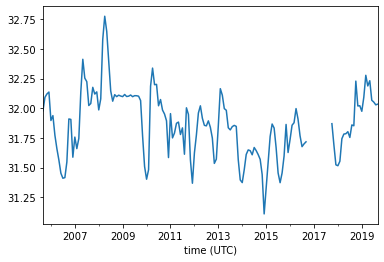

In [34]:
sdata.salinity_f35[sdata.salinity_f35 <30.5] = np.nan
sdata.salinity_f35[sdata.salinity_f35 >33] = np.nan
sdata_mmean = sdata.salinity_f35.resample('1M').mean()
sdata_mmean.plot()

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(sdata.salinity_f35.groupby([sdata.index.month]).mean())

time (UTC)
1     31.730500
2     31.806835
3     31.962738
4     32.029843
5     32.009159
6     31.907009
7     31.847598
8     31.817949
9     31.857446
10    31.912260
11    31.815276
12    31.667339
Name: salinity_f35, dtype: float64


In [36]:
smean = (31.847598+31.817949+31.860616) / 3

In [45]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print((sdata_mmean - smean)[(sdata_mmean - smean).index.month == 7])
    print((sdata_mmean - smean)[(sdata_mmean - smean).index.month == 8])
    print((sdata_mmean - smean)[(sdata_mmean - smean).index.month == 9])    

time (UTC)
2006-07-31 00:00:00+00:00   -0.431722
2007-07-31 00:00:00+00:00    0.381976
2008-07-31 00:00:00+00:00    0.304059
2009-07-31 00:00:00+00:00    0.263925
2010-07-31 00:00:00+00:00    0.179056
2011-07-31 00:00:00+00:00   -0.007386
2012-07-31 00:00:00+00:00    0.009594
2013-07-31 00:00:00+00:00   -0.024320
2014-07-31 00:00:00+00:00   -0.172649
2015-07-31 00:00:00+00:00   -0.387021
2016-07-31 00:00:00+00:00   -0.165567
2017-07-31 00:00:00+00:00         NaN
2018-07-31 00:00:00+00:00   -0.087979
2019-07-31 00:00:00+00:00    0.210102
Name: salinity_f35, dtype: float64
time (UTC)
2006-08-31 00:00:00+00:00   -0.426263
2007-08-31 00:00:00+00:00    0.181198
2008-08-31 00:00:00+00:00    0.217521
2009-08-31 00:00:00+00:00    0.263534
2010-08-31 00:00:00+00:00    0.231436
2011-08-31 00:00:00+00:00   -0.229499
2012-08-31 00:00:00+00:00    0.051789
2013-08-31 00:00:00+00:00    0.003264
2014-08-31 00:00:00+00:00   -0.199004
2015-08-31 00:00:00+00:00   -0.469133
2016-08-31 00:00:00+00:00   -0.

In [48]:
import altair as alt
### own colormap
import palettable

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [77]:
f1 = alt.Chart((sdata_mmean - smean).reset_index()).mark_rect().encode(
    alt.X('month(time (UTC)):O', title=''),
    alt.Y('year(time (UTC)):O', title=''),
    alt.Color('salinity_f35:Q', title='', scale=alt.Scale(range=palettable.cmocean.diverging.Balance_20.hex_colors)),
    tooltip=['hoursminutes(time (UTC)):O','monthdate(time (UTC)):O','salinity_f35:Q']
).properties(
    width=720
)
f1

alt.Chart(...)

In [90]:
cfile = '/Users/bell/in_and_outbox/2020/mordy/M8_DIN/daily_data/M8_uv_50m.median.csv'
cdata = pd.read_csv(cfile,parse_dates=True,index_col='time')
cdata['cd'] = np.arctan2(cdata.v_1206_f35,cdata.u_1205_f35)
cdata['cs'] = np.sqrt(cdata.v_1206_f35**2 + cdata.u_1205_f35**2)

In [92]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
print(cmocean.cm.cmapnames)

from matplotlib.dates import (
    YearLocator,
    WeekdayLocator,
    MonthLocator,
    DayLocator,
    HourLocator,
    DateFormatter,
)
import matplotlib.ticker as ticker

class Timeseries1dStickPlot(object):

    mpl.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['pdf.fonttype'] = 42
    
    def __init__(self, fontsize=10, labelsize=10, plotstyle='k-.', stylesheet='bmh'):
        """Initialize the timeseries with items that do not change.

        This sets up the axes and station locations. The `fontsize` and `spacing`
        are also specified here to ensure that they are consistent between individual
        station elements.

        Parameters
        ----------
        fontsize : int
            The fontsize to use for drawing text
        labelsize : int
          The fontsize to use for labels
        stylesheet : str
          Choose a mpl stylesheet [u'seaborn-darkgrid', 
          u'seaborn-notebook', u'classic', u'seaborn-ticks', 
          u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', 
          u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', 
          u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', 
          u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', 
          u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', 
          u'seaborn-dark-palette']
        """

        self.fontsize = fontsize
        self.labelsize = labelsize
        self.plotstyle = plotstyle
        plt.style.use(stylesheet)

    @staticmethod
    def add_title(mooringid='',lat=-99.9,lon=-99.9,depth=9999,instrument=''):
      """Pass parameters to annotate the title of the plot

      This sets the standard plot title using common meta information from PMEL/EPIC style netcdf files

      Parameters
      ----------
      mooringid : str
        Mooring Identifier
      lat : float
        The latitude of the mooring
      lon : float
        The longitude of the mooring
      depth : int
        Nominal depth of the instrument
      instrument : str
        Name/identifier of the instrument plotted
      """  
      ptitle = ("Plotted on: {time:%Y/%m/%d %H:%M} \n from {mooringid} Lat: {latitude:3.3f}  Lon: {longitude:3.3f}" 
            " Depth: {depth}\n : {instrument}").format(
            time=datetime.datetime.now(), 
                  mooringid=mooringid,
                  latitude=lat, 
                  longitude=lon, 
                  depth=depth,
                  instrument=instrument )

      return ptitle


    def plot(self, timedata=None, udata=None, vdata=None, ylabel=None, linescale=1, **kwargs):

      if kwargs['rotate'] != 0.0:
          #when rotating vectors - positive(+) rotation is equal to cw of the axis (ccw of vector)
          #                      - negative(+) rotation is equal to ccw of the axis (cw of the vector)
          print("rotating vectors")
          angle_offset_rad = np.deg2rad(kwargs['rotate'])
          udata = udata*np.cos(angle_offset_rad) + vdata*np.sin(angle_offset_rad)
          vdata = -1.*udata*np.sin(angle_offset_rad) + vdata*np.cos(angle_offset_rad)

      magnitude = np.sqrt(udata**2 + vdata**2)

      fig, (ax1,ax2) = plt.subplots(2,1,sharex='col',figsize=(11,4.25))


      # Plot u and v components
      # Plot quiver
      ax1.set_ylim(-1*np.nanmax(magnitude), np.nanmax(magnitude))
      fill1 = ax1.fill_between(timedata, magnitude, 0, color='k', alpha=0.1)

      # Fake 'box' to be able to insert a legend for 'Magnitude'
      """
      p = ax1.add_patch(plt.Rectangle((1,1),1,1,fc='k',alpha=0.1))
      leg1 = ax1.legend([p], ["Current magnitude [cm/s]"],loc='lower right')
      leg1._drawFrame=False
      """

      # 1D Quiver plot
      q = ax1.quiver(timedata,0,udata,vdata,color='r',units='y',scale_units='y',
                     scale = 1,headlength=1,headaxislength=1,width=0.04*linescale,alpha=.95)
      qk = plt.quiverkey(q,0.2, 0.05, 5,r'$5 \frac{cm}{s}$',labelpos='W',
                     fontproperties={'weight': 'bold'})


      # Plot u and v components
      ax1.set_xticklabels(ax1.get_xticklabels(), visible=False)
      ax2.set_xticklabels(ax2.get_xticklabels(), visible=True)
      ax1.axes.get_xaxis().set_visible(False)
      ax1.set_xlim(timedata.min(),timedata.max())
      ax1.set_ylabel("Velocity (cm/s)")
      ax2.plot(timedata, vdata, 'b-', linewidth=0.25)
      ax2.plot(timedata, udata, 'g-', linewidth=0.25)
      ax2.set_xlim(timedata.min(),timedata.max())
      ax2.set_xlabel("Date (UTC)")
      ax2.set_ylabel("Velocity (cm/s)")
      ax2.xaxis.set_major_locator(MonthLocator())
      ax2.xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13), bymonthday=15))
      ax2.xaxis.set_major_formatter(ticker.NullFormatter())
      ax2.xaxis.set_minor_formatter(DateFormatter('%b %y'))
      ax1.spines['bottom'].set_visible(False)
      ax2.spines['top'].set_visible(False)
      ax1.xaxis.set_ticks_position('top')
      ax2.xaxis.set_ticks_position('bottom')
      ax2.yaxis.set_ticks_position('both')
      ax2.tick_params(axis='both', which='minor', labelsize=self.labelsize)
      ax1.tick_params(axis='both', which='minor', labelsize=self.labelsize)
      #manual time limit sets
      #ax1.set_xlim([datetime.datetime(2016,2,1),datetime.datetime(2016,9,15)])
      #ax2.set_xlim([datetime.datetime(2016,2,1),datetime.datetime(2016,9,15)])
      # Set legend location - See: http://matplotlib.org/Volumes/WDC_internal/users/legend_guide.html#legend-location
      leg2 = plt.legend(['v','u'],loc='upper left')
      leg2._drawFrame=False


      return plt, fig

['thermal', 'haline', 'solar', 'ice', 'gray', 'oxy', 'deep', 'dense', 'algae', 'matter', 'turbid', 'speed', 'amp', 'tempo', 'rain', 'phase', 'topo', 'balance', 'delta', 'curl', 'diff', 'tarn']


/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To c

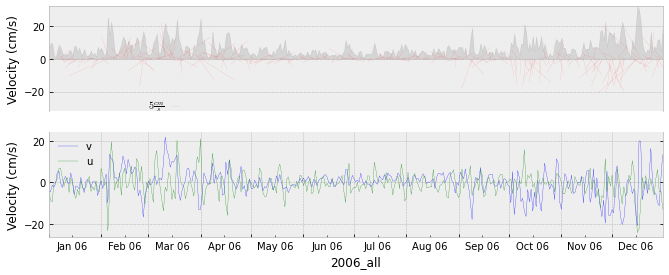

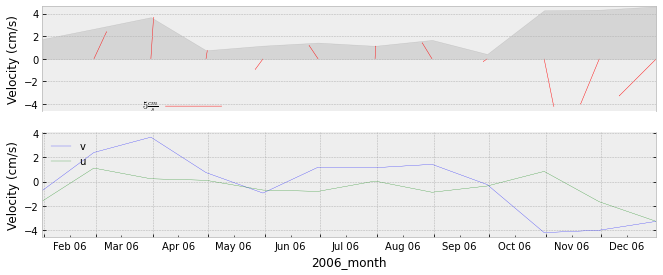

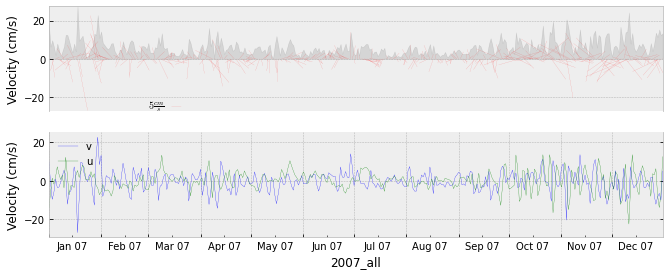

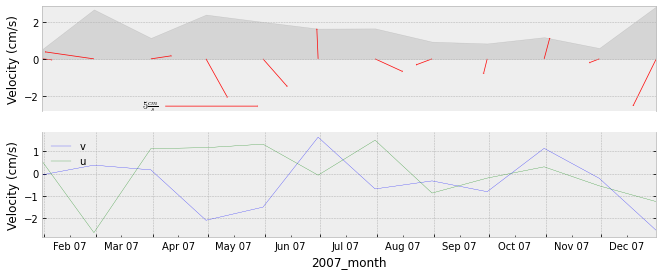

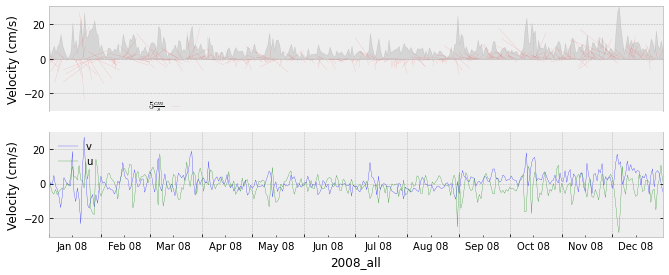

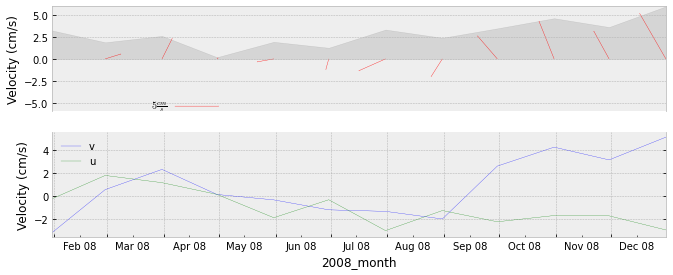

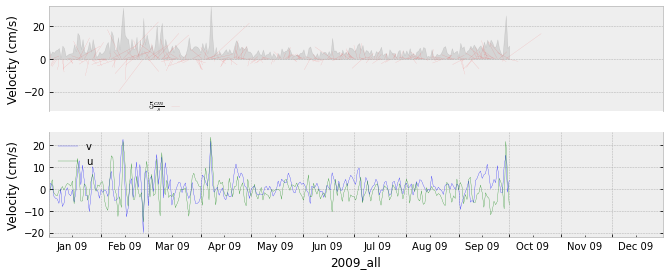

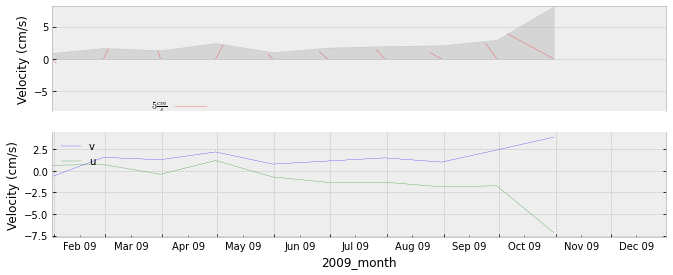

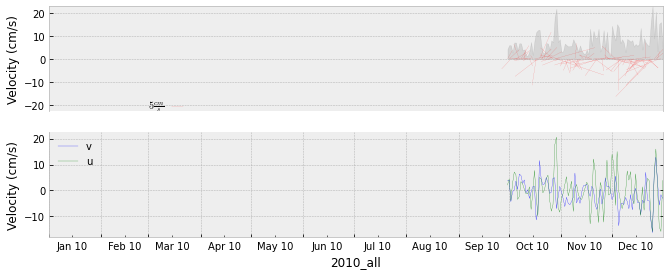

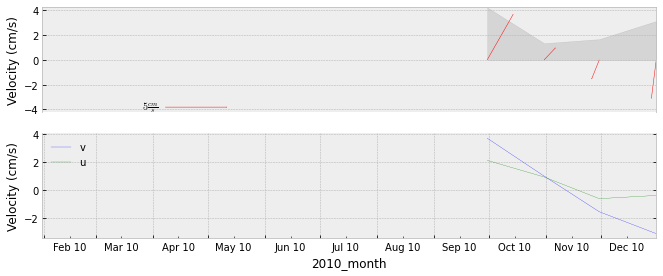

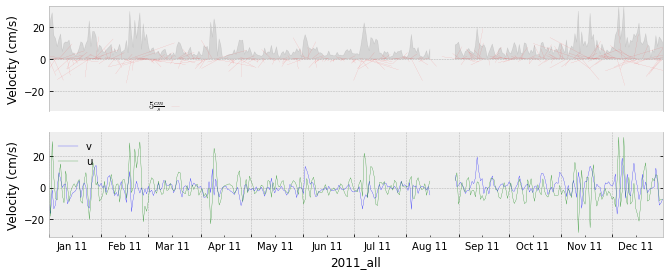

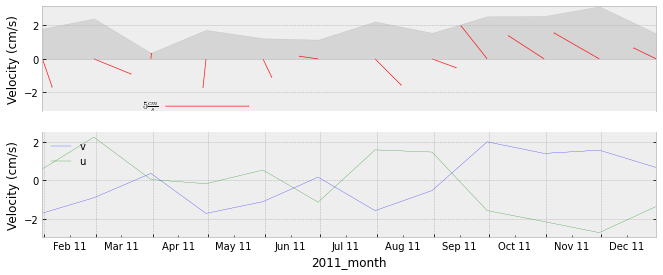

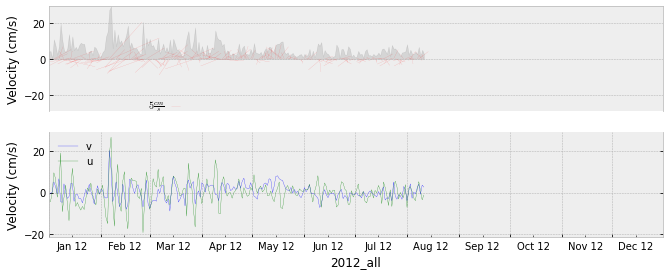

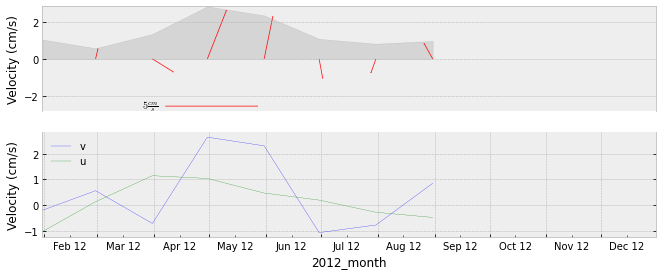

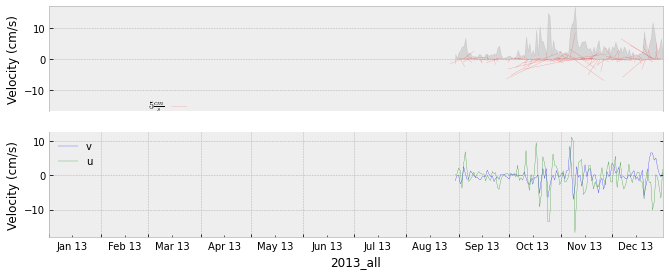

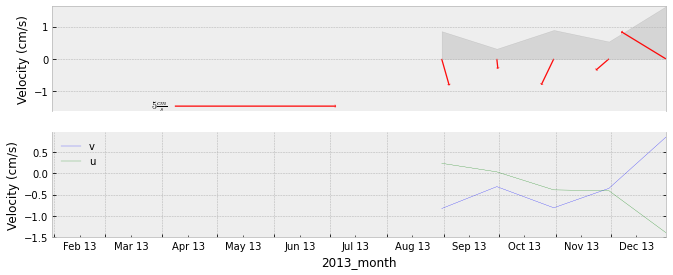

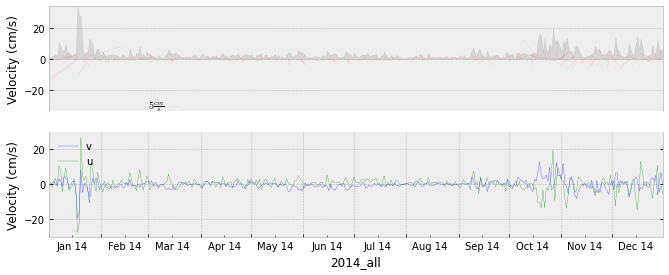

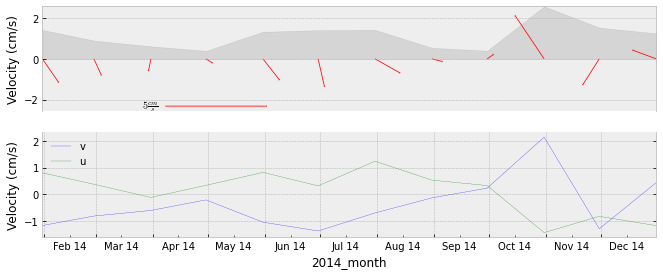

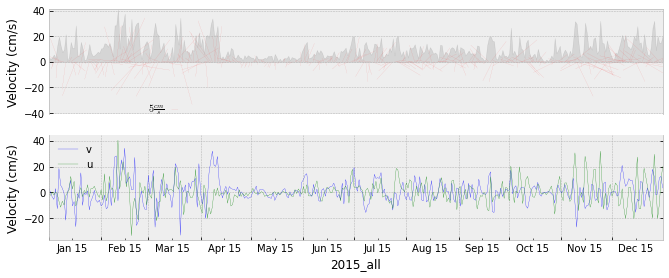

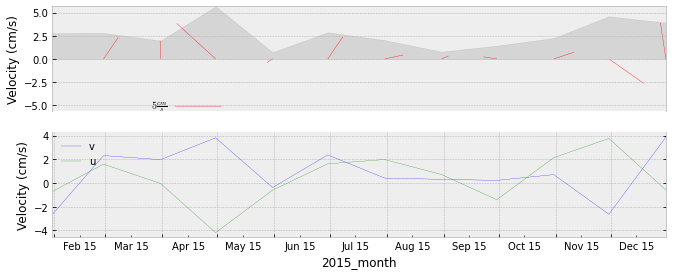

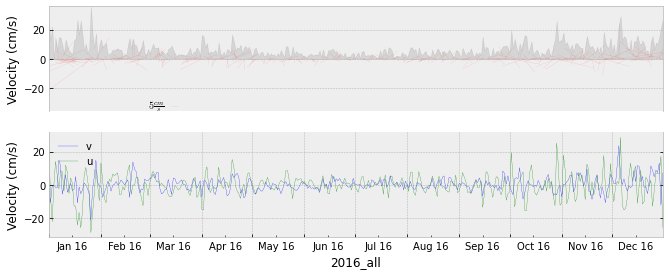

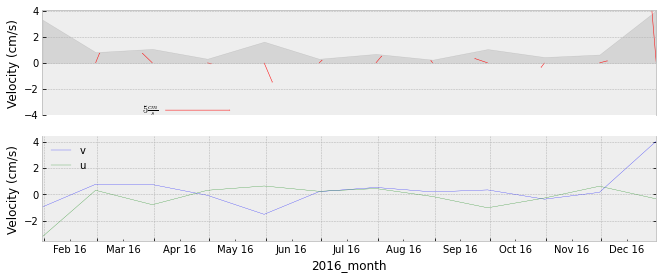

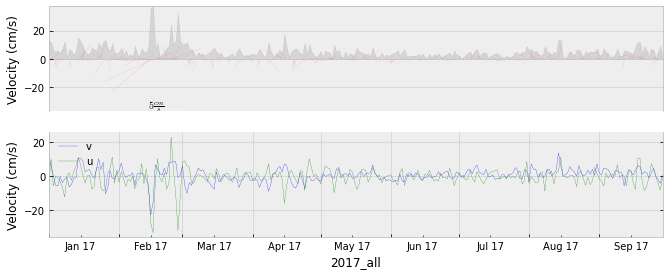

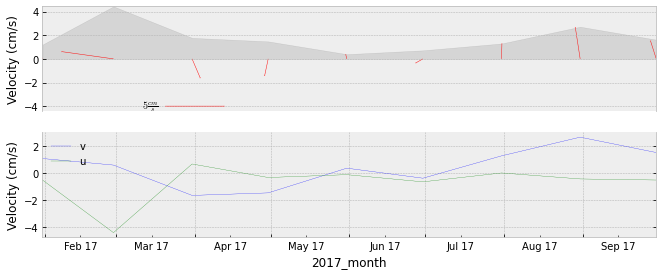

In [101]:
for year in range(2006,2018):
    tdata =cdata[cdata.index.year==year]
    p1 = Timeseries1dStickPlot()
    plt1, fig1 = p1.plot(timedata=tdata.index, 
                         udata=tdata.u_1205_f35.values, 
                         vdata=tdata.v_1206_f35.values,
                         rotate=0)
    plt1.xlabel(str(year)+'_all')

    tdata =cdata[cdata.index.year==year].resample('1M').mean()
    p1 = Timeseries1dStickPlot()
    plt1, fig1 = p1.plot(timedata=tdata.index, 
                         udata=tdata.u_1205_f35.values, 
                         vdata=tdata.v_1206_f35.values,
                         rotate=0)
    plt1.xlabel(str(year)+'_month')